# Use Bedrock and Stable Diffusion to create a contact sheet with throttling

When creating multiple images, this throttling can limit a users ability to quickly produce images. For example, when trying to produce an example image to give a model as a reference image.

## Inference parameters

Here are Stable Diffusion 3 (and 3.5) **inference parameters**, this does not include using an example image.

* **prompt**: (string) min: 0, max: 1000 number of tokens
* **negative_prompt**: Keywords of what you do not wish to see in the output image. Max: 10,000 characters.
* **aspect_ratio**: (string) Controls the aspect ratio of the generated image.  This parameter is only valid for text-to-image requests. Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
* **mode**: Controls whether this is a text-to-image or image-to-image generation, which affects which parameters are required. Default: text-to-image. Enum: image-to-image, text-to-image.
* **output_format**: Specifies the format of the output image. Supported formats: JPEG, PNG. Supported dimensions: height 640 to 1,536 px, width 640 to 1,536 px.
* **seed**: (number): A specific value that is used to guide the 'randomness' of the generation. (Omit this parameter or pass 0 to use a random seed.) Range: 0 to 4294967295.
* **strength**: (number): From 0 and 1 (inclusive)

## Using a class

For this project I will use a class. This allows for the image creating to be done once or in a for loop.



In [ ]:
pip install boto3 pillow

In [1]:
# Import as needed
import os
import io
import re
import json
import time
import boto3
import base64
import random
from PIL import Image
from botocore.config import Config
from IPython.display import Image as IPy_Image

In [2]:
# Setup the class
class SDTxt2ImgInference:
    def __init__(self, 
                 model_id="stability.sd3-5-large-v1:0",
                 prompt="A stylized picture of a cute old steampunk otter",
                 seed=0,
                 negative_prompt=None,
                 mode="text-to-image",
                 strength=1,
                 output_format="png",
                 aspect_ratio="1:1",
                 ):
        """
        Class initialization, setting defaults
        The seed here is used as a placeholder, with the for loop random is called for each API call
        """
        
        self.negative_prompt = negative_prompt
        self.mode = mode
        self.strength = strength
        self.output_format = output_format
        self.aspect_ratio = aspect_ratio
        self.prompt = prompt
        self.seed = seed
        self.model_id = model_id 

        # Setup the bedrock client
        # Setting client reties to 1 results a faster response from the API when being throttled,
        #  the default is 4 retries
        config = Config(
           retries = {
              'max_attempts': 1,
              'mode': 'standard'
           }
        )
        self.bedrock = boto3.client('bedrock-runtime', region_name='us-west-2', config=config)

    
    def runInference(self):
        """
        Run Stable Diffusion inference with the given prompt and parameters.
        
        Seed is local for generating a different random number on for loops.

        Currently there is a static (2 sec) throttle, and not an exponential backoff
        
        TBD: Exponetial backoff instead of static throttle   
        """
        _seed = random.randint(0, 4294967295)

        _request = json.dumps({
            'prompt': self.prompt,
            'seed': _seed,
            'aspect_ratio': self.aspect_ratio,
            'output_format': self.output_format,
            'mode': self.mode,
            'strength': self.strength,
        })

        _throttlingLimit = False
        while True:
            try:
                response = self.bedrock.invoke_model(modelId=self.model_id, body=_request)
                break
            except self.bedrock.exceptions.ValidationException as e:
                print(f"Error: {e.response['Error']['Message']}")
                exit(1) 
            except self.bedrock.exceptions.ThrottlingException as e:
                # print(f"Error: {e.response['Error']['Message']}")
                if _throttlingLimit:
                    print(".", end="", flush=True)
                    time.sleep(2)
                else:
                    print(f"Hit throttling limit, waiting...", end="", flush=True)
                    _throttlingLimit = True
                    time.sleep(2)
        return response

    
    def getImageData(self):
        """
        Get the image data from the repsonse, and decode in to the image object
        """
        response = self.runInference()
        output_body = json.loads(response["body"].read().decode("utf-8"))
        base64_output_image = output_body["images"][0]
        image_data = base64.b64decode(base64_output_image)
        return Image.open(io.BytesIO(image_data))


    def runImagePipeline(self):
        """
        Steps:
            Get the image data
            Convert prompt text string in to a file name
            Check for an existing file name, and increment {i} when needed
            Save the generated image to a local folder name "bedrock_output"
        """

        image = self.getImageData()
        output_filename = self.prompt.strip() 
        output_filename = output_filename.replace(" ", "_")
        output_filename = output_filename.rstrip(".")
        output_filename = re.sub(r'[^\w\s-]', '', output_filename)
        output_filename = re.sub(r'[-\s]+', '-', output_filename)
        output_filename = output_filename[:50]
        
        i, self.output_dir = 1, "bedrock_output"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        while os.path.exists(os.path.join(self.output_dir, f"{output_filename}_{i}.png")):
            i += 1
        
        image_path = os.path.join(self.output_dir, f"{output_filename}_{i}.png")
        
        try:
            image.save(image_path)
            print(f"\nGenerated image saved: {image_path}")
        except Exception as e:
            print(f"Error: {e}")

        return image_path
        

    def mkContactSheet(self,cols=None,rows=None):
        """
        Creates a contact sheet of images, using .thumbnail from PIL

        Args:
            image_paths: List of paths to the images
            cols: Number of columns in the contact sheet
            rows: Number of rows in the contact sheet
            output_path: Path to save the output contact sheet
        """

        images = [Image.open(self.output_dir + "/" + file) for file in os.listdir(self.output_dir) if not file.startswith('.')]

        # Calculate thumbnail size
        thumbnail_width = images[0].width // cols
        thumbnail_height = images[0].height // rows

        # Create a new image for the contact sheet
        contact_sheet = Image.new(
            'RGB', 
            (thumbnail_width * cols, thumbnail_height * rows)
        )

        # Paste images into the contact sheet
        x = 0
        y = 0
        for img in images:
            img.thumbnail((thumbnail_width, thumbnail_height))
            contact_sheet.paste(img, (x, y))
            x += thumbnail_width
            if x >= thumbnail_width * cols:
                x = 0
                y += thumbnail_height

        # Save contact sheet
        contact_sheet_path = f"{self.output_dir}/contact_sheet.jpg"
        try:
            contact_sheet.save(contact_sheet_path, "JPEG")
            print(f"Contact sheet saved: {contact_sheet_path}")
        except Exception as e:
            print(f"Error: {e}")

        return contact_sheet_path



In [3]:
# Instantiate class
prompt="""A stylized picture of a cute old steampunk bear""".replace('\n', ' ')
sd_image = SDTxt2ImgInference(prompt=prompt)

In [4]:
%%time
# Generate the image, and save the path to the image
gen_image_path = sd_image.runImagePipeline()


Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_1.png
CPU times: user 164 ms, sys: 33.9 ms, total: 198 ms
Wall time: 7.36 s


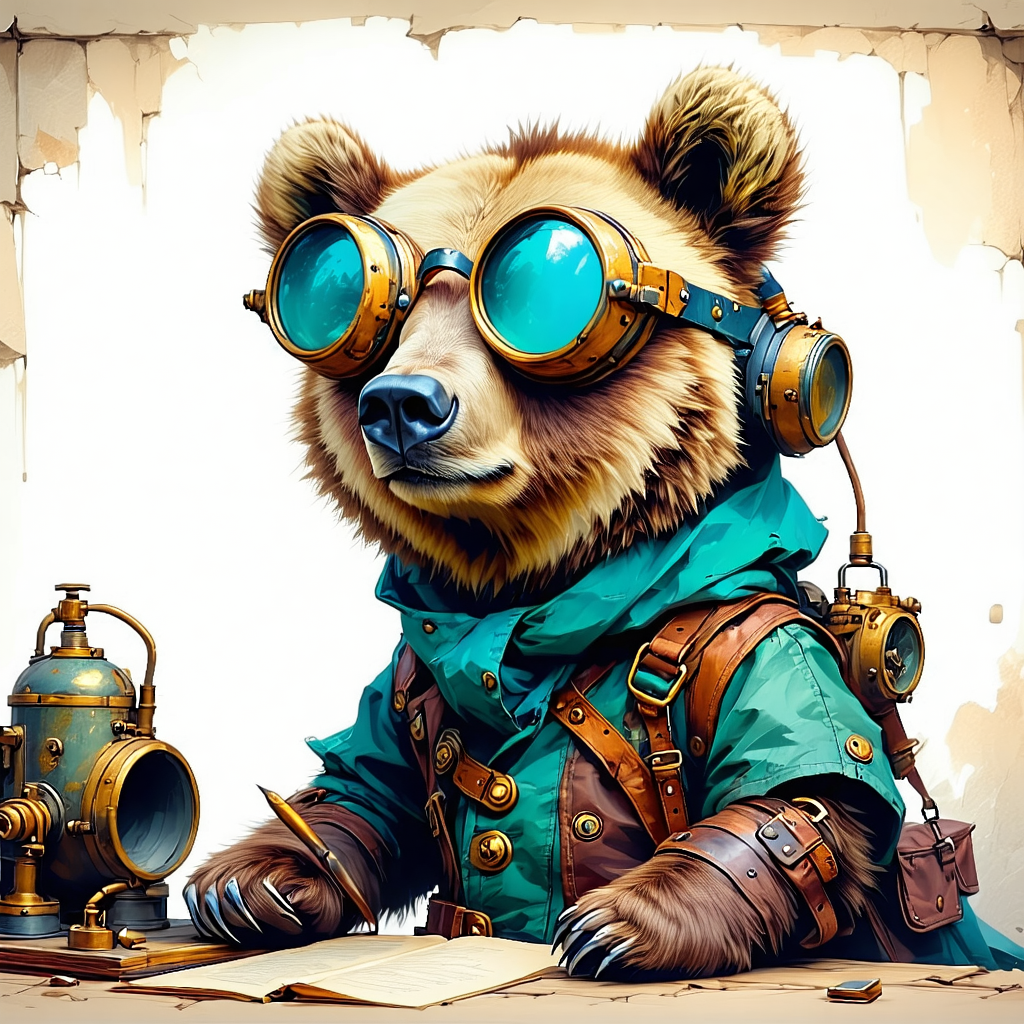

In [5]:
# Display the image
img = IPy_Image(filename=gen_image_path, width=600)
display(img)

In [6]:
# Remove the single image that was just created
if os.path.isfile(gen_image_path):
    os.remove(gen_image_path)
    print(f"Removed file: {gen_image_path}")

Removed file: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_1.png


In [7]:
%%time
# Run the same pipeline, creating a contact sheet
# This will create a 3x3 (9 image) contact sheet
cols=3
rows=3
total=cols*rows
while total > 0:
    sd_image.runImagePipeline()
    total-=1
contact_sheet_path=sd_image.mkContactSheet(cols, rows)


Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_1.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_2.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_3.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_4.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_5.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_6.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_7.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_8.png

Generated image saved: bedrock_output/A_stylized_picture_of_a_cute_old_steampunk_bear_9.png
Contact sheet saved: bedrock_output/contact_sheet.jpg
CPU times: user 1.45 s, sys: 301 ms, total: 1.75 s
Wall time: 1min 22s


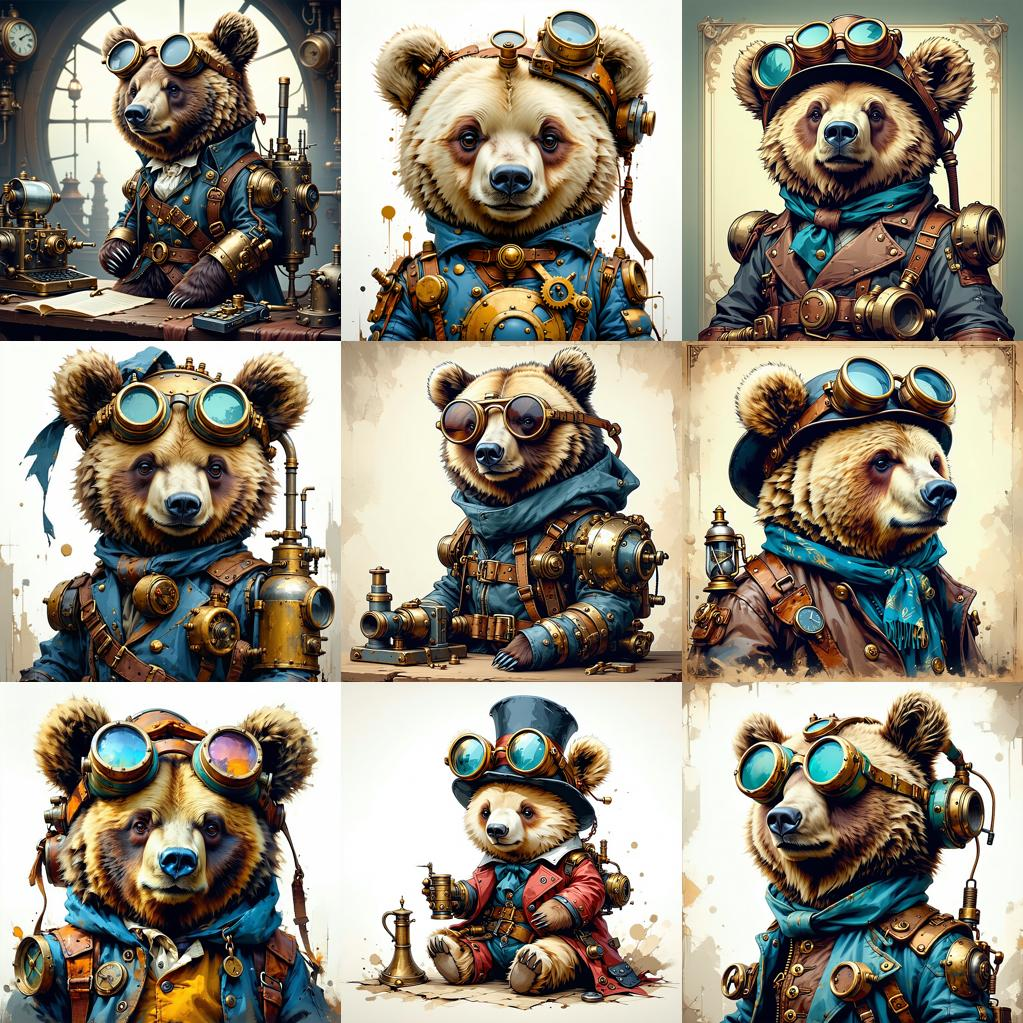

In [8]:
# Display the contact sheet
img = IPy_Image(filename=contact_sheet_path, width=800)
display(img)